In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Read Data

In [3]:
df = pd.read_json("interaction.json", lines=True)

# Transform into Tabular data

## High-level Keys

In [4]:
res = pd.DataFrame()
res["visitorId"] = [s["visitorId"]["S"] for s in df["Item"]]
res["eventId"] = [s["eventId"]["S"] for s in df["Item"]]
res["ttl"] = [s["ttl"]["N"] for s in df["Item"]]
res["data"] = [s["data"]["M"] for s in df["Item"]]
res.head()

,visitorId,eventId,ttl,data
0,23a9d176cb0a6f4e41f26bb61167bd78,job-search-waitstaff,1631185958.2,{'viewedAt': {'S': '2021-08-10T11:12:37.145Z'}...
1,820c8d6b90bfc3154ea241f20383313c,job-view-52939023,1629198877.076,"{'jobId': {'S': '52939023'}, 'roleId': {'S': '..."
2,906053f95a33732f207cdded4ebcb320,job-search-aged-care-physiotherapist,1629873562.072,{'viewedAt': {'S': '2021-07-26T06:39:21.174Z'}...
3,de3043ff16009134fe548446c1b84b1f,job-search-business-development,1631236371.018,{'viewedAt': {'S': '2021-08-11T01:12:50.446Z'}...
4,1a48d73af464a96f4b7365261d605147,job-search-office-administrator,1630667899.384,{'viewedAt': {'S': '2021-08-04T11:18:18.968Z'}...


In [5]:
print(res.shape)

(1109520, 4)


# Separate three type of events

This is because we see that the additional data is dependent on the type of event, so it will be easier to further flatten the data if we dedicate separate tabular dataframes to each type of even

In [6]:
def get_sub_data(df, targetColumn, substring, newColumName):
    res = df[df[targetColumn].str.contains(substring)]
    res[targetColumn] = [s.replace(substring, "") for s in res[targetColumn]]
    res = res.rename(columns={targetColumn: newColumName})
    return res

def collect_all_keys(df, col):
    allKeys = []
    for s in df[col]:
        allKeys.extend(s.keys())
        
    return set(allKeys)

def clean_type_value_pair(pair):
    if pair == None:
        return np.nan
    if 'N' in pair:
        return int(pair['N'])
    elif 'S':
        return str(pair['S'])

def day_section(h):
    if h>=5 and h<9:
        return "early-morning"
    elif h>=9 and h<12:
        return "late-morning"
    elif h>=12 and h<15:
        return "early-afternoon"
    elif h>=15 and h<18:
        return "late-afternoon"
    elif h>=18 and h<21:
        return "early-evening"
    elif h>=21 and h<24:
        return "late-evening"
    else:
        return "past-midnight"
    
def enrich_columns(df, targetColumn, prefix=None):
    subColumns = collect_all_keys(df, targetColumn)
    for col in subColumns:
        df[col] = [clean_type_value_pair(s.get(col)) for s in df[targetColumn]]
    if "viewedAt" in df.columns:
        df["viewedAt"] = pd.to_datetime(df["viewedAt"])
        df["date"] = df['viewedAt'].dt.date
        df["day_of_the_week"] = df['viewedAt'].dt.day_name()
        df["month_of_the_year"] = df['viewedAt'].dt.month_name()
        df["hour_of_the_day"] = df['viewedAt'].dt.hour
        df["day_section"] = [day_section(h) for h in df["hour_of_the_day"]]
    return df.drop(columns=[targetColumn]).reset_index(drop=True)

def prefix_columns(df, prefix, exclude=[]):
    df.columns = [prefix+str(col) if col not in exclude else col for col in df.columns]

### Event: Article View

In [7]:
articleDf = get_sub_data(res, "eventId", "article-view-", "article_name")
articleDf = enrich_columns(articleDf, "data")
articleDf.head()

,visitorId,article_name,ttl,alias,tag,articleId,mainCategoryId,topCategoryId,viewedAt,date,day_of_the_week,month_of_the_year,hour_of_the_day,day_section
0,1bb87dcbd0ee049d06dc435b3aa05715,the-5-skills-employers-want-now-and-how-to-sho...,1629182763.529,the-5-skills-employers-want-now-and-how-to-sho...,NaN,9090,522,top-2,2021-07-18 06:46:03.001000+00:00,2021-07-18,Sunday,July,6,early-morning
1,01fd8ac24911eeb68b02c57119590cd7,5-ways-to-deal-with-a-micromanaging-boss,1630782253.138,5-ways-to-deal-with-a-micromanaging-boss,Settled,701,519,top-2,2021-08-05 19:04:11.673000+00:00,2021-08-05,Thursday,August,19,early-evening
2,84a1de7f19962bb47229c8fa09ec45b9,5-ways-to-deal-with-a-micromanaging-boss,1629048840.676,5-ways-to-deal-with-a-micromanaging-boss,Settled,701,519,top-2,2021-07-16 17:33:59.421000+00:00,2021-07-16,Friday,July,17,late-afternoon
3,6b058834e5f9b399d2f2a5acaed810f9,how-to-answer-where-do-you-see-yourself-in-5-y...,1630297155.412,how-to-answer-where-do-you-see-yourself-in-5-y...,Active,331,82,top-1,2021-07-31 04:19:14.610000+00:00,2021-07-31,Saturday,July,4,past-midnight
4,be495cb086f0a1ac6e0b13ef2bbbe36b,free-resume-template,1628832286.052,free-resume-template,Active,12,289,top-0,2021-07-14 05:24:45.205000+00:00,2021-07-14,Wednesday,July,5,early-morning


### Event: Job View

In [8]:
jobViewDf = get_sub_data(res, "eventId", "job-view-", "job_number")
jobViewDf = enrich_columns(jobViewDf, "data")
jobViewDf.head()

,visitorId,job_number,ttl,jobId,locationId,class,workType,source,viewedAt,roleId,date,day_of_the_week,month_of_the_year,hour_of_the_day,day_section
0,820c8d6b90bfc3154ea241f20383313c,52939023,1629198877.076,52939023,5061,6163,Full Time,web,2021-07-18 11:14:36.259000+00:00,care-coordinator,2021-07-18,Sunday,July,11,late-morning
1,3124ccf1f4a299a5a619cb69a5b2ac24,53096747,1629565817.937,53096747,1002,6092,Contract/Temp,web,2021-07-22 17:10:16.919000+00:00,warehouse-operator,2021-07-22,Thursday,July,17,late-afternoon
2,bd028c3b0e14f0c0ce9c157c50bcbc89,52765158,1629330148.315,52765158,1002,1209,Full Time,web,2021-07-19 23:42:27.565000+00:00,safety-engineer,2021-07-19,Monday,July,23,late-evening
3,8204f1a52774ddf567403901aab347ec,52784534,1630154087.209,52784534,1000,1210,Full Time,web,2021-07-29 12:34:46.642000+00:00,talent-acquisition-consultant,2021-07-29,Thursday,July,12,early-afternoon
4,53278fbd8061da990a9e0715150e96db,52914193,1630199890.077,52914193,5047,1204,Full Time,web,2021-07-30 01:18:09.283000+00:00,sales-support,2021-07-30,Friday,July,1,past-midnight


### Event: Job Search

In [9]:
jobSearchDf = get_sub_data(res, "eventId", "job-search-", "search_phrase")
jobSearchDf = enrich_columns(jobSearchDf, "data")
print(jobSearchDf.shape)
jobSearchDf.head()

(517620, 13)


,visitorId,search_phrase,ttl,keywords,where,source,viewedAt,roleId,date,day_of_the_week,month_of_the_year,hour_of_the_day,day_section
0,23a9d176cb0a6f4e41f26bb61167bd78,waitstaff,1631185958.2,NaN,All Adelaide SA,web,2021-08-10 11:12:37.145000+00:00,waitstaff,2021-08-10,Tuesday,August,11,late-morning
1,906053f95a33732f207cdded4ebcb320,aged-care-physiotherapist,1629873562.072,physiotherapist,Rockhampton & Capricorn Coast QLD,web,2021-07-26 06:39:21.174000+00:00,aged-care-physiotherapist,2021-07-26,Monday,July,6,early-morning
2,de3043ff16009134fe548446c1b84b1f,business-development,1631236371.018,intern,NaN,web,2021-08-11 01:12:50.446000+00:00,business-development,2021-08-11,Wednesday,August,1,past-midnight
3,1a48d73af464a96f4b7365261d605147,office-administrator,1630667899.384,no experience,All Canberra ACT,web,2021-08-04 11:18:18.968000+00:00,office-administrator,2021-08-04,Wednesday,August,11,late-morning
4,87ab366c176cfcd792d4da020fabed78,Warehouse-Administration-Officer,1629597413.083,NaN,NaN,web,2021-07-23 01:56:52.167000+00:00,Warehouse-Administration-Officer,2021-07-23,Friday,July,1,past-midnight


In [10]:
# rename columns
prefix_columns(jobSearchDf, "job_search_", exclude=["visitorId"])
prefix_columns(jobViewDf, "job_view_", exclude=["visitorId"])
prefix_columns(articleDf, "article_view_", exclude=["visitorId"])

# Search to View

In [11]:
# merging on visitor id
searchToView = jobSearchDf.merge(jobViewDf, on=["visitorId"], how="left")
print(searchToView.shape)
searchToView.head(5)

(609612, 27)


,visitorId,job_search_search_phrase,job_search_ttl,job_search_keywords,job_search_where,job_search_source,job_search_viewedAt,job_search_roleId,job_search_date,job_search_day_of_the_week,...,job_view_class,job_view_workType,job_view_source,job_view_viewedAt,job_view_roleId,job_view_date,job_view_day_of_the_week,job_view_month_of_the_year,job_view_hour_of_the_day,job_view_day_section
0,23a9d176cb0a6f4e41f26bb61167bd78,waitstaff,1631185958.2,NaN,All Adelaide SA,web,2021-08-10 11:12:37.145000+00:00,waitstaff,2021-08-10,Tuesday,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,906053f95a33732f207cdded4ebcb320,aged-care-physiotherapist,1629873562.072,physiotherapist,Rockhampton & Capricorn Coast QLD,web,2021-07-26 06:39:21.174000+00:00,aged-care-physiotherapist,2021-07-26,Monday,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,de3043ff16009134fe548446c1b84b1f,business-development,1631236371.018,intern,NaN,web,2021-08-11 01:12:50.446000+00:00,business-development,2021-08-11,Wednesday,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,1a48d73af464a96f4b7365261d605147,office-administrator,1630667899.384,no experience,All Canberra ACT,web,2021-08-04 11:18:18.968000+00:00,office-administrator,2021-08-04,Wednesday,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,87ab366c176cfcd792d4da020fabed78,Warehouse-Administration-Officer,1629597413.083,NaN,NaN,web,2021-07-23 01:56:52.167000+00:00,Warehouse-Administration-Officer,2021-07-23,Friday,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
TimeIntervalThreshold = 60 # in minutes
# creating the time interval column
searchToView["search_to_view_interval_in_minutes"] = (searchToView.job_view_viewedAt - searchToView.job_search_viewedAt).astype('timedelta64[m]')
searchToView["converted"] = [1 if (t>=0) and (t<TimeIntervalThreshold) else 0 for t in searchToView["search_to_view_interval_in_minutes"]]
print(searchToView.shape)
searchToView.head(6)

(609612, 29)


,visitorId,job_search_search_phrase,job_search_ttl,job_search_keywords,job_search_where,job_search_source,job_search_viewedAt,job_search_roleId,job_search_date,job_search_day_of_the_week,...,job_view_source,job_view_viewedAt,job_view_roleId,job_view_date,job_view_day_of_the_week,job_view_month_of_the_year,job_view_hour_of_the_day,job_view_day_section,search_to_view_interval_in_minutes,converted
0,23a9d176cb0a6f4e41f26bb61167bd78,waitstaff,1631185958.2,NaN,All Adelaide SA,web,2021-08-10 11:12:37.145000+00:00,waitstaff,2021-08-10,Tuesday,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,906053f95a33732f207cdded4ebcb320,aged-care-physiotherapist,1629873562.072,physiotherapist,Rockhampton & Capricorn Coast QLD,web,2021-07-26 06:39:21.174000+00:00,aged-care-physiotherapist,2021-07-26,Monday,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,de3043ff16009134fe548446c1b84b1f,business-development,1631236371.018,intern,NaN,web,2021-08-11 01:12:50.446000+00:00,business-development,2021-08-11,Wednesday,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1a48d73af464a96f4b7365261d605147,office-administrator,1630667899.384,no experience,All Canberra ACT,web,2021-08-04 11:18:18.968000+00:00,office-administrator,2021-08-04,Wednesday,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,87ab366c176cfcd792d4da020fabed78,Warehouse-Administration-Officer,1629597413.083,NaN,NaN,web,2021-07-23 01:56:52.167000+00:00,Warehouse-Administration-Officer,2021-07-23,Friday,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,af01d030e95292f2ae091d87fb950274,team-member,1631248159.538,cafe,bunbury,web,2021-08-11 04:29:18.748000+00:00,team-member,2021-08-11,Wednesday,...,web,2021-08-11 05:27:07.547000+00:00,support-worker,2021-08-11,Wednesday,August,5.0,early-morning,57.0,1


## Benchamark statistics

In [13]:
def group_conversions(targetDf, groupCols, totalDf, targetCol="converted"):
    conv = targetDf.groupby(groupCols)[targetCol].sum().reset_index()
    total = targetDf.groupby(groupCols).agg(total=("visitorId", 'count')).reset_index()
    res = conv.merge(total, on=groupCols)
    res["conversion_ratio"] = res["converted"]/res["total"]
    return res

In [14]:
convSearchToView = sum(searchToView["converted"])/len(jobSearchDf)
print("Conversaion rate from search to view is {:.2%}".format(convSearchToView))

Conversaion rate from search to view is 4.06%


## day of the week

In [15]:
dailySearchToViewConversions = group_conversions(searchToView, ["job_search_day_of_the_week"], jobSearchDf)
dailySearchToViewConversions

,job_search_day_of_the_week,converted,total,conversion_ratio
0,Friday,2451,72640,0.033742
1,Monday,3171,95409,0.033236
2,Saturday,1915,55722,0.034367
3,Sunday,1880,58790,0.031978
4,Thursday,2937,93510,0.031408
5,Tuesday,4602,117886,0.039038
6,Wednesday,4055,115655,0.035061


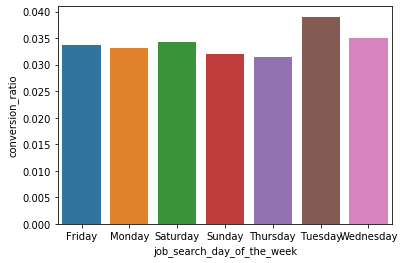

In [16]:
sns.barplot(x="job_search_day_of_the_week", y="conversion_ratio", data=dailySearchToViewConversions)

## day of the week and section of the day

In [17]:
dailySectionSearchToViewConversions = group_conversions(searchToView, ["job_search_day_of_the_week", "job_search_day_section"], jobSearchDf)
dailySectionSearchToViewConversions.head(50)

,job_search_day_of_the_week,job_search_day_section,converted,total,conversion_ratio
0,Friday,early-afternoon,374,7549,0.049543
1,Friday,early-evening,67,3191,0.020997
2,Friday,early-morning,545,17400,0.031322
3,Friday,late-afternoon,139,3769,0.036880
4,Friday,late-evening,203,6635,0.030595
5,Friday,late-morning,443,11461,0.038653
6,Friday,past-midnight,680,22635,0.030042
7,Monday,early-afternoon,360,9295,0.038731
8,Monday,early-evening,77,3587,0.021466
9,Monday,early-morning,851,23668,0.035956


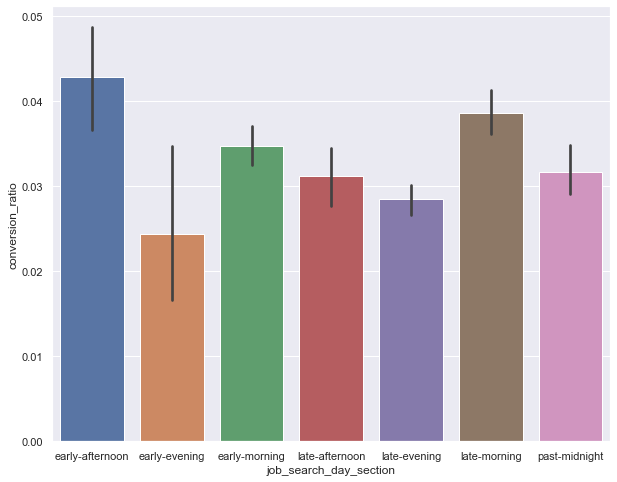

In [59]:
#plot and conclusion
sns.set(rc = {'figure.figsize':(10,8)})
sns.barplot(x="job_search_day_section", y="conversion_ratio", data=dailySectionSearchToViewConversions)

In [21]:
## location
locationSearchToViewConversions = group_conversions(searchToView, ["job_search_where"], jobSearchDf)
locationSearchToViewConversions.head(10)

,job_search_where,converted,total,conversion_ratio
0,A,0,1,0.0
1,Adelaide SA,0,1,0.0
2,Cairns,1,2,0.5
3,Canberra,0,1,0.0
4,Canberra,0,1,0.0
5,Gold Coast QLD,0,1,0.0
6,H,0,1,0.0
7,Melbourne VIC,0,8,0.0
8,Melbourne western suburbs,0,1,0.0
9,NSW,0,6,0.0


## Text Analytics

In [22]:
import string
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')

def cosine_sim(text1, text2):
    if pd.isnull(text1) or pd.isnull(text2):
        return 0.0
    a = text1.lower().replace("-"," ")
    b = text2.lower().replace("-"," ")
    tfidf = vectorizer.fit_transform([a, b])
    return ((tfidf * tfidf.T).A)[0,1]

def jaccard_sim(str1, str2):
    if pd.isnull(str1) or pd.isnull(str2):
        return 0.0
    a = set(str1.lower().replace("-"," ").split(" ")) 
    b = set(str2.lower().replace("-"," ").split(" "))
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [23]:
searchToView["keyword_vs_roleId_similarity"] = \
        [jaccard_sim(s1, s2) for s1, s2 in zip(searchToView['job_view_roleId'],
                                               searchToView['job_search_keywords'])]

searchToView["search_phrase_vs_roleId_similarity"] = \
        [jaccard_sim(s1, s2) for s1, s2 in zip(searchToView['job_view_roleId'],
                                               searchToView['job_search_search_phrase'])]

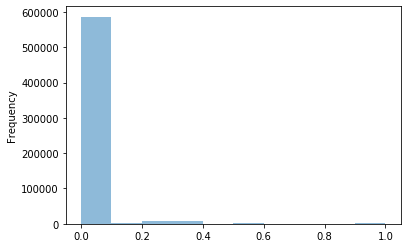

In [24]:
searchToView.search_phrase_vs_roleId_similarity.plot.hist(bins=10, alpha=0.5)

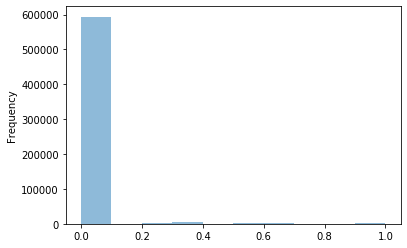

In [25]:
searchToView.keyword_vs_roleId_similarity.plot.hist(bins=10, alpha=0.5)

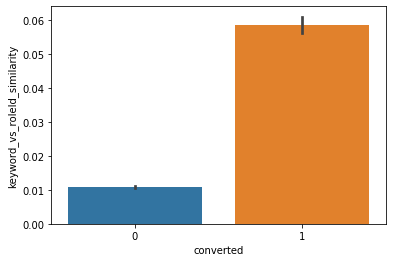

In [27]:
sns.barplot(x="converted", y="keyword_vs_roleId_similarity", data=searchToView)

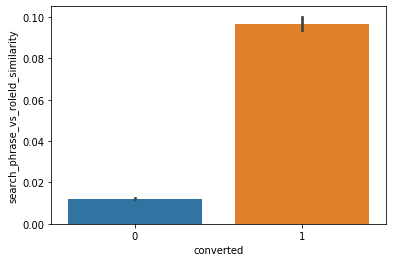

In [28]:
sns.barplot(x="converted", y="search_phrase_vs_roleId_similarity", data=searchToView)

In [29]:
searchToView[searchToView["converted"]==1][["job_search_search_phrase", "job_view_roleId", "search_phrase_vs_roleId_similarity"]].head(10)

,job_search_search_phrase,job_view_roleId,search_phrase_vs_roleId_similarity
5,team-member,support-worker,0.0
9,business-intelligence-developer,pmo-analyst,0.0
31,housekeeper,tutor,0.0
35,data-entry-clerk,environmental-officer,0.0
53,bookkeeper,contact-centre-specialist,0.0
64,service-concierge,carer,0.0
78,business-management-graduate,consultant,0.0
102,geotechnical-engineer,geotechnical-engineer,1.0
112,technical-support-engineer,control-systems-engineer,0.2
113,accountant,administration-officer,0.0


# Search to Article

In [30]:
# merging on visitor id
searchToArticle = jobSearchDf.merge(articleDf, on=["visitorId"], how="left")
print(searchToArticle.shape)

# creating the time interval column
searchToArticle["view_to_article_interval_in_minutes"] = (searchToArticle.article_view_viewedAt - searchToArticle.job_search_viewedAt).astype('timedelta64[m]')
searchToArticle["converted"] = [1 if t>=0 else 0 for t in searchToArticle["view_to_article_interval_in_minutes"]]
print(searchToArticle.shape)
searchToArticle.head(6)

(517710, 26)
(517710, 28)


,visitorId,job_search_search_phrase,job_search_ttl,job_search_keywords,job_search_where,job_search_source,job_search_viewedAt,job_search_roleId,job_search_date,job_search_day_of_the_week,...,article_view_mainCategoryId,article_view_topCategoryId,article_view_viewedAt,article_view_date,article_view_day_of_the_week,article_view_month_of_the_year,article_view_hour_of_the_day,article_view_day_section,view_to_article_interval_in_minutes,converted
0,23a9d176cb0a6f4e41f26bb61167bd78,waitstaff,1631185958.2,NaN,All Adelaide SA,web,2021-08-10 11:12:37.145000+00:00,waitstaff,2021-08-10,Tuesday,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0
1,906053f95a33732f207cdded4ebcb320,aged-care-physiotherapist,1629873562.072,physiotherapist,Rockhampton & Capricorn Coast QLD,web,2021-07-26 06:39:21.174000+00:00,aged-care-physiotherapist,2021-07-26,Monday,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0
2,de3043ff16009134fe548446c1b84b1f,business-development,1631236371.018,intern,NaN,web,2021-08-11 01:12:50.446000+00:00,business-development,2021-08-11,Wednesday,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1a48d73af464a96f4b7365261d605147,office-administrator,1630667899.384,no experience,All Canberra ACT,web,2021-08-04 11:18:18.968000+00:00,office-administrator,2021-08-04,Wednesday,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0
4,87ab366c176cfcd792d4da020fabed78,Warehouse-Administration-Officer,1629597413.083,NaN,NaN,web,2021-07-23 01:56:52.167000+00:00,Warehouse-Administration-Officer,2021-07-23,Friday,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0
5,af01d030e95292f2ae091d87fb950274,team-member,1631248159.538,cafe,bunbury,web,2021-08-11 04:29:18.748000+00:00,team-member,2021-08-11,Wednesday,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0


## Benchamark statistics

In [31]:
convSearchToArticle = sum(searchToArticle["converted"])/len(jobSearchDf)
print("Conversaion rate from job search to article view is {:.2%}".format(convSearchToArticle))

Conversaion rate from job search to article view is 0.08%


In [51]:
dailySearchToArticleConversions = group_conversions(searchToArticle, ["job_search_day_of_the_week"], jobSearchDf)
dailySearchToArticleConversions.head(10)

,job_search_day_of_the_week,converted,total,conversion_ratio
0,Friday,44,61648,0.000714
1,Monday,61,83114,0.000734
2,Saturday,102,46082,0.002213
3,Sunday,21,52857,0.000397
4,Thursday,70,79050,0.000886
5,Tuesday,64,97655,0.000655
6,Wednesday,62,97304,0.000637


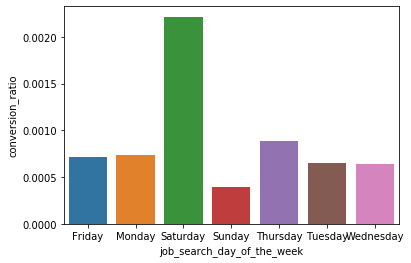

In [52]:
sns.barplot(x="job_search_day_of_the_week", y="conversion_ratio", data=dailySearchToArticleConversions)

In [53]:
dailySectionSearchToArticleConversions = group_conversions(searchToView, ["job_search_day_of_the_week", "job_search_day_section"], jobSearchDf)
dailySectionSearchToArticleConversions.head(10)

,job_search_day_of_the_week,job_search_day_section,converted,total,conversion_ratio
0,Friday,early-afternoon,374,7549,0.049543
1,Friday,early-evening,67,3191,0.020997
2,Friday,early-morning,545,17400,0.031322
3,Friday,late-afternoon,139,3769,0.036880
4,Friday,late-evening,203,6635,0.030595
5,Friday,late-morning,443,11461,0.038653
6,Friday,past-midnight,680,22635,0.030042
7,Monday,early-afternoon,360,9295,0.038731
8,Monday,early-evening,77,3587,0.021466
9,Monday,early-morning,851,23668,0.035956


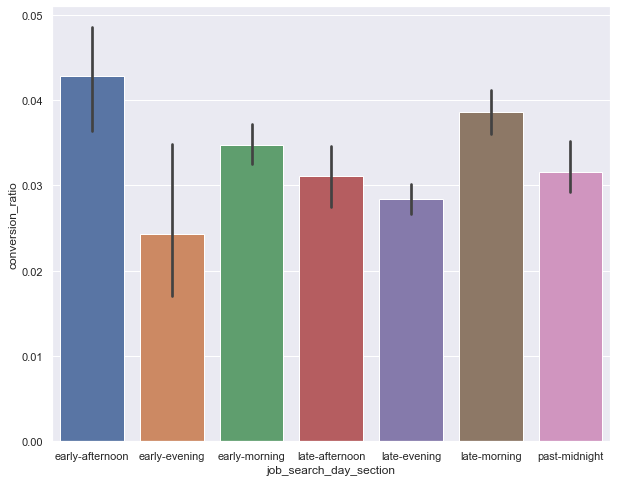

In [58]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.barplot(x="job_search_day_section", y="conversion_ratio", data=dailySectionSearchToArticleConversions)

## Text Analytics

In [37]:
searchToArticle["roleId_vs_articleName_similarity"] = \
        [jaccard_sim(s1, s2) for s1, s2 in zip(searchToArticle['job_search_search_phrase'],
                                               searchToArticle['article_view_article_name'])]

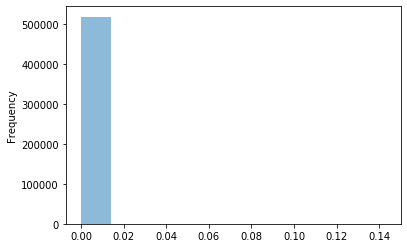

In [38]:
searchToArticle.roleId_vs_articleName_similarity.plot.hist(bins=10, alpha=0.5)

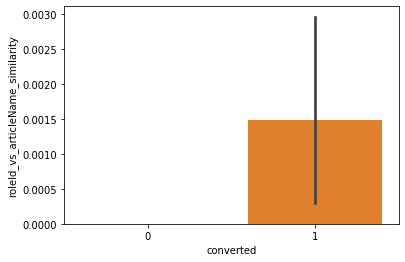

In [39]:
sns.barplot(x="converted", y="roleId_vs_articleName_similarity", data=searchToArticle)

In [40]:
searchToArticle[(searchToArticle["converted"]==1)&(searchToArticle["roleId_vs_articleName_similarity"]>0)][["job_search_search_phrase", "article_view_article_name", "roleId_vs_articleName_similarity"]]

,job_search_search_phrase,article_view_article_name,roleId_vs_articleName_similarity
7521,group-general-manager,3-books-every-manager-should-read,0.125000
36937,construction-manager,3-books-every-manager-should-read,0.142857
67625,health-and-wellbeing-coordinator,cover-letters-the-good-and-the-bad,0.111111
231199,digital-marketing-manager,3-books-every-manager-should-read,0.125000
423238,key-account-manager,3-books-every-manager-should-read,0.125000


In [41]:
print(articleDf.shape)
articleDf.groupby("article_view_article_name").agg(count=("visitorId", 'count')).reset_index().sort_values(by="count", ascending=False)

(17695, 14)


,article_view_article_name,count
91,8-things-to-cut-from-your-cover-letter-right-now,1785
153,download-seeks-free-standard-resignation-lette...,1543
63,5-ways-to-deal-with-a-micromanaging-boss,1042
173,free-cover-letter-template,812
174,free-resume-template,719
...,...,...
359,stay-ahead-while-quitting,1
358,starting-your-first-job-heres-how-to-make-the-...,1
357,so-you-didnt-get-that-promotion-now-what,1
254,how-to-reinvent-yourself,1


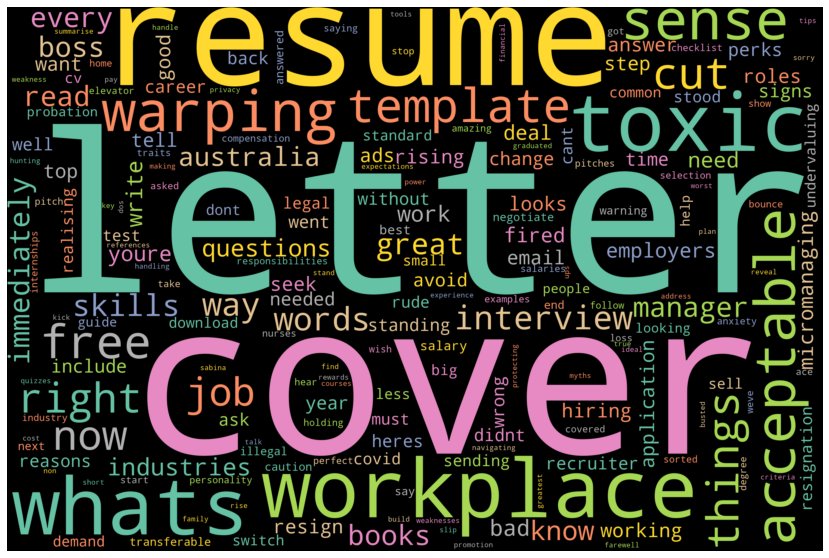

In [64]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

text = (" ".join(searchToArticle[searchToArticle["converted"]==1]["article_view_article_name"]))

# Generate a word cloud image
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS).generate(text)
# Display the generated image:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()